# *SOURCE*
https://www.youtube.com/watch?v=doDUihpj6ro&t=7339s
https://github.com/nicknochnack/ActionDetectionforSignLanguage

In [1]:
! pip install PyQt5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.8/357.8 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 11.8 MB/s eta 0:00:00


In [2]:
!pip install tensorflow==2.8.1 tensorflow-gpu==2.8.1 opencv-python mediapipe 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 101.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully u

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [4]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/content/Tutorial_LSTM_MP/Complete_CheatDataNiko') 

# Actions that we try to detect
actions = np.array(['LirikKanan', 'LirikKiri', 'MenolehKanan', 'MenolehKiri', 'Normal', 'TutupMata'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 50

In [5]:
! git clone https://github.com/nickbp760/Tutorial_LSTM_MP.git

Cloning into 'Tutorial_LSTM_MP'...
remote: Enumerating objects: 37889, done.
remote: Counting objects: 100% (14877/14877), done.
remote: Compressing objects: 100% (10175/10175), done.
remote: Total 37889 (delta 4707), reused 14865 (delta 4696), pack-reused 23012
Receiving objects: 100% (37889/37889), 635.58 MiB | 22.83 MiB/s, done.
Resolving deltas: 100% (4912/4912), done.
Updating files: 100% (31884/31884), done.


### **Preprocess Data and Create Labels and Features**

The label map containts the action label

In [6]:
label_map = {label:num for num, label in enumerate(actions)}

In [7]:
label_map

{'LirikKanan': 0,
 'LirikKiri': 1,
 'MenolehKanan': 2,
 'MenolehKiri': 3,
 'Normal': 4,
 'TutupMata': 5}

load the the data that have been prepared before

In [8]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [9]:
np.array(sequences).shape

(180, 50, 15)

DEFINE X (Input) and y (Output)

In [10]:
X = np.array(sequences)
print(X.shape)
y = to_categorical(labels).astype(int)
print(y.shape)

(180, 50, 15)
(180, 6)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [12]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    

### **Build and Train Neural Network**

In [27]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [35]:
model = Sequential()
model.add(GRU(128, return_sequences=True, activation='relu', input_shape=(50,15)))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(GRU(128, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.optimizer.lr.assign(0.0001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [37]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback], validation_data = (X_test, y_test))

Epoch 1/100
6/6 [==============================] - 6s 426ms/step - loss: 1.7688 - categorical_accuracy: 0.1667 - val_loss: 1.7484 - val_categorical_accuracy: 0.1667
Epoch 2/100
6/6 [==============================] - 4s 783ms/step - loss: 1.7340 - categorical_accuracy: 0.1667 - val_loss: 1.7200 - val_categorical_accuracy: 0.3333
Epoch 3/100
6/6 [==============================] - 4s 630ms/step - loss: 1.7074 - categorical_accuracy: 0.1975 - val_loss: 1.6901 - val_categorical_accuracy: 0.3333
Epoch 4/100
6/6 [==============================] - 3s 530ms/step - loss: 1.6744 - categorical_accuracy: 0.2593 - val_loss: 1.6594 - val_categorical_accuracy: 0.3333
Epoch 5/100
6/6 [==============================] - 2s 318ms/step - loss: 1.6517 - categorical_accuracy: 0.3210 - val_loss: 1.6284 - val_categorical_accuracy: 0.3333
Epoch 6/100
6/6 [==============================] - 2s 324ms/step - loss: 1.6202 - categorical_accuracy: 0.3519 - val_loss: 1.5963 - val_categorical_accuracy: 0.5556
Epoch 7/10

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 50, 128)           55680     
                                                                 
 dropout_8 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_11 (GRU)                (None, 50, 64)            37248     
                                                                 
 dropout_9 (Dropout)         (None, 50, 64)            0         
                                                                 
 gru_12 (GRU)                (None, 128)               74496     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 32)               

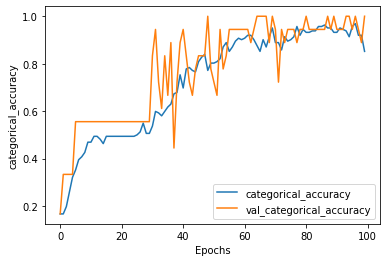

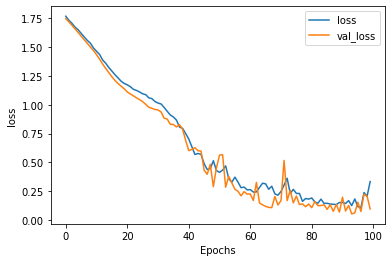

In [38]:
model.summary()
model.save('/content/Tutorial_LSTM_MP/Weight_model/actionGRUCheatData.h5')
plot_graphs(history, 'categorical_accuracy')
plot_graphs(history, 'loss')

In [39]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(50,15)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.optimizer.lr.assign(0.0001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [41]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback], validation_data = (X_test, y_test))

Epoch 1/100
6/6 [==============================] - 6s 350ms/step - loss: 1.7908 - categorical_accuracy: 0.2469 - val_loss: 1.7199 - val_categorical_accuracy: 0.2778
Epoch 2/100
6/6 [==============================] - 2s 262ms/step - loss: 1.7495 - categorical_accuracy: 0.2284 - val_loss: 1.6783 - val_categorical_accuracy: 0.3889
Epoch 3/100
6/6 [==============================] - 2s 264ms/step - loss: 1.7035 - categorical_accuracy: 0.2716 - val_loss: 1.6054 - val_categorical_accuracy: 0.4444
Epoch 4/100
6/6 [==============================] - 2s 278ms/step - loss: 1.6446 - categorical_accuracy: 0.2901 - val_loss: 1.4982 - val_categorical_accuracy: 0.4444
Epoch 5/100
6/6 [==============================] - 2s 361ms/step - loss: 1.5883 - categorical_accuracy: 0.2963 - val_loss: 1.4373 - val_categorical_accuracy: 0.4444
Epoch 6/100
6/6 [==============================] - 4s 603ms/step - loss: 1.5274 - categorical_accuracy: 0.2840 - val_loss: 1.3967 - val_categorical_accuracy: 0.4444
Epoch 7/10

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 128)           73728     
                                                                 
 dropout_10 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50, 64)            49408     
                                                                 
 dropout_11 (Dropout)        (None, 50, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               98816     
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 32)               

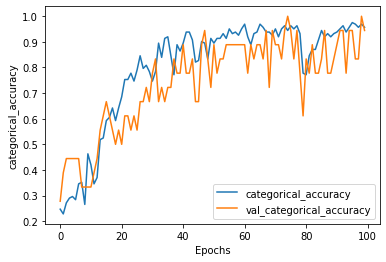

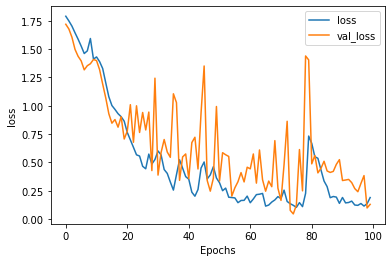

In [42]:
model.summary()
model.save('/content/Tutorial_LSTM_MP/Weight_model/actionLSTMCheatData.h5')
plot_graphs(history, 'categorical_accuracy')
plot_graphs(history, 'loss')